<a href="https://colab.research.google.com/github/lakshh670/100_days_of_DeepLearning/blob/main/Transfer_Learning_Fine_Tuning(With_Data_Augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In this notebook we will perform fine tuning with data augmentation. We are going to build a model which can do face detection.

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from keras.applications.vgg16 import VGG16
# We are using VGG16 model which is trained on imagenet dataset.

# Splitting the images into train and test.

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/images.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import shutil
import random

SOURCE_DIR = "/content/images"     # extracted images folder
DEST_DIR = "/content/Dataset"

TRAIN_RATIO = 0.8
random.seed(42)

In [5]:
for split in ["train", "validation"]:
    for cls in ["masked", "unmasked"]:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)


In [6]:
files = sorted(
    os.listdir(SOURCE_DIR),
    key=lambda x: int(os.path.splitext(x)[0])
)


In [7]:
masked_files = files[:408]
random.shuffle(masked_files)

split_idx = int(408 * TRAIN_RATIO)
masked_train = masked_files[:split_idx]
masked_val = masked_files[split_idx:]


In [8]:
unmasked_files = files[408:]
random.shuffle(unmasked_files)

split_idx = int(408 * TRAIN_RATIO)
unmasked_train = unmasked_files[:split_idx]
unmasked_val = unmasked_files[split_idx:]


In [9]:
def copy_files(file_list, split, cls):
    for f in file_list:
        shutil.copy(
            os.path.join(SOURCE_DIR, f),
            os.path.join(DEST_DIR, split, cls, f)
        )

copy_files(masked_train, "train", "masked")
copy_files(masked_val, "validation", "masked")

copy_files(unmasked_train, "train", "unmasked")
copy_files(unmasked_val, "validation", "unmasked")


# Load the dataset

In [24]:
train=keras.utils.image_dataset_from_directory('/content/Dataset/train',image_size=(150,150))
test=keras.utils.image_dataset_from_directory('/content/Dataset/validation',image_size=(150,150))


Found 652 files belonging to 2 classes.
Found 164 files belonging to 2 classes.


21

# Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)

In [15]:
train_generator=train_datagen.flow_from_directory('/content/Dataset/train',target_size=(150,150),class_mode='binary')
test_generator=test_datagen.flow_from_directory('/content/Dataset/validation',target_size=(150,150),class_mode='binary')



Found 652 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


# Model Building

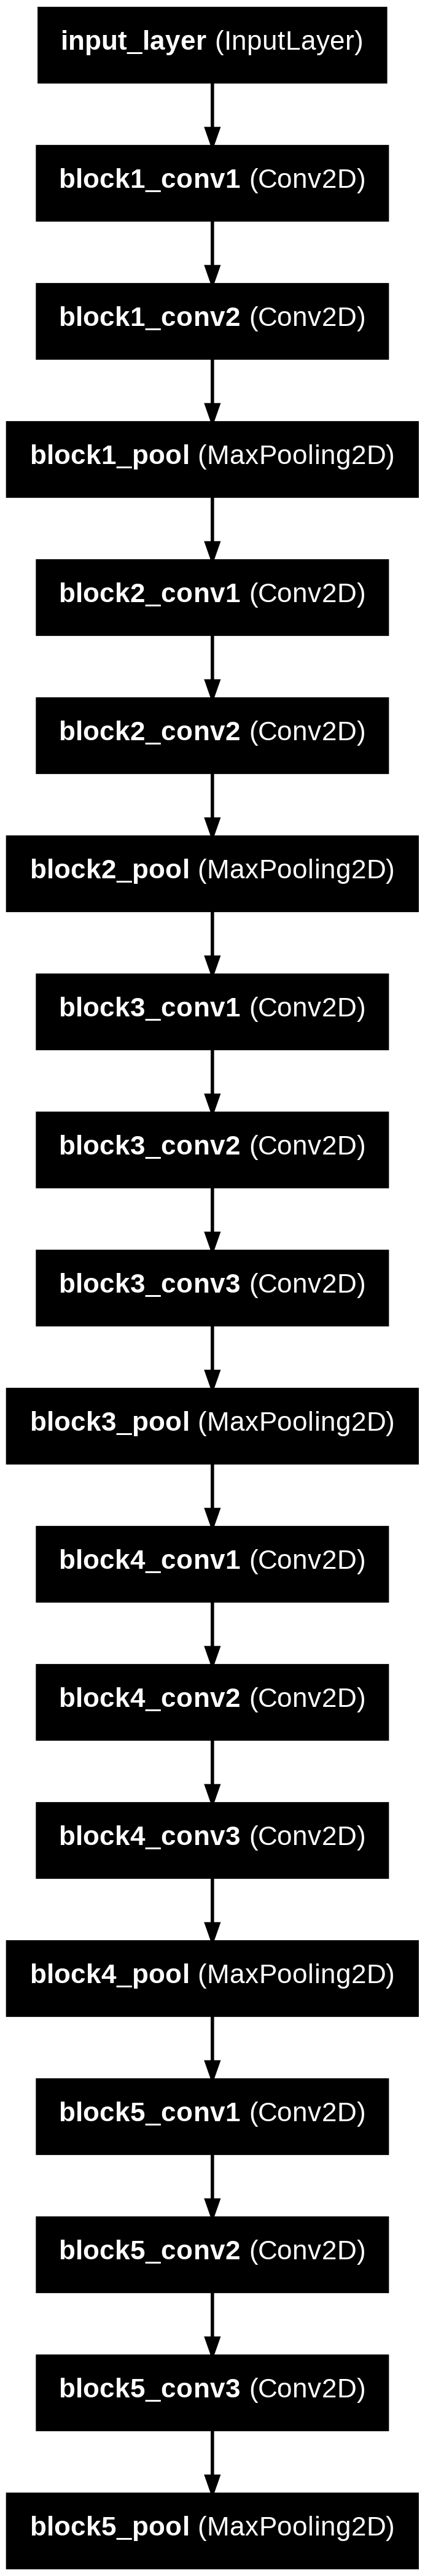

In [19]:
from keras.src.utils import plot_model
plot_model(conv_base,show_layer_names=True)

In [28]:
conv_base=VGG16(include_top=False)
conv_base.trainable=False
set_trainable=False
for layers in conv_base.layers:
  if layers.name=='block5_conv1':
    set_trainable=True
  layers.trainable=True

In [29]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 256) for variable path='sequential_2/dense_3/kernel'

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
model.fit(train_generator,steps_per_epoch=652//32,epochs=10,validation_steps=164//32,validation_data=test_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 4, 4, 1)